In [1]:
#Setup Data
apikey  = 'QHOA07WHc6ZkNS2A9i4bTcTbYuOpEqLI3eHu6iWp02gDOnmwMFpQsSQDO4nytISY'
secret = 'yvHF7zGHB9CVj8cSHQb0j8cZdjhfNSdJ7FcWJuvIfVlNcCh4aT6UneTJRjcokzH9'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import warnings
from termcolor import colored
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
    
warnings.filterwarnings('ignore')

#Autenticate
client = Client(apikey, secret)
print("Client initialized successfully")

Client initialized successfully


In [2]:
#Chose to load a Historical Data

import pywt
def seconds_per_interval(interval: str) -> int:
    seconds_per_unit = {
        "s": 1,
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60,
    }
    try:
        return int(interval[:-1]) * seconds_per_unit[interval[-1]] * 1000
    except (ValueError, KeyError):
        return None

data_selections = input("Enter the data selection (e.g., BTCUSDT_15m): ")

file_path = fr'C:\Users\DJKlaKunG\Desktop\Personal_Document\GitHub\CNN-Bi-LSTM-Research\training-data\SWT-CNN-Bi-LSTM-Model-2\{data_selections}_data.csv'

# Split the data_selections string into TICKET and interval
TICKET, interval_str = data_selections.rsplit('_', 1)

# Map the interval string to its corresponding KLINE_INTERVAL attribute
interval_map = {
    '1m': Client.KLINE_INTERVAL_1MINUTE,
    '3m': Client.KLINE_INTERVAL_3MINUTE,
    '5m': Client.KLINE_INTERVAL_5MINUTE,
    '15m': Client.KLINE_INTERVAL_15MINUTE,
    '30m': Client.KLINE_INTERVAL_30MINUTE,
    '1h': Client.KLINE_INTERVAL_1HOUR,
    '2h': Client.KLINE_INTERVAL_2HOUR,
    '4h': Client.KLINE_INTERVAL_4HOUR,
    '6h': Client.KLINE_INTERVAL_6HOUR,
    '8h': Client.KLINE_INTERVAL_8HOUR,
    '12h': Client.KLINE_INTERVAL_12HOUR,
    '1d': Client.KLINE_INTERVAL_1DAY,
    '3d': Client.KLINE_INTERVAL_3DAY,
    '1w': Client.KLINE_INTERVAL_1WEEK,
    '1M': Client.KLINE_INTERVAL_1MONTH,
}

KLINE_INTERVAL = interval_map.get(interval_str, None)
if KLINE_INTERVAL is None:
    print(f"Invalid interval: {interval_str}")
else:
    seconds = seconds_per_interval(KLINE_INTERVAL)
    if seconds is None:
        print(f"Cannot convert interval '{KLINE_INTERVAL}' to milliseconds.")

    
if os.path.exists(file_path):
    print("Found Request file")
    print(f"Requesting {TICKET} - {interval_str}")
    hist_df = pd.read_csv(file_path)
    print(f"Requesting {TICKET} - {interval_str} - Complete")
else:
    print(f"{TICKET} - {interval_str} data is not available")
    print(f"Attempting to retrieve {TICKET} - {interval_str}")
    historical = client.get_historical_klines(TICKET, KLINE_INTERVAL, '1 Jan 2019')
    print(f"Requesting Complete")
    print(f"Sorting Data columes...")
    hist_df = pd.DataFrame(historical)
    hist_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                        'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
    
    hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
    hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
    hist_df[numeric_columns] = hist_df[numeric_columns].apply(pd.to_numeric, axis=1)
    hist_df['Gain'] = hist_df['Close'].diff().clip(lower=0)  # Positive differences only
    hist_df['Loss'] = -hist_df['Close'].diff().clip(upper=0)  # Negative differences only, converted to positive values
    # Calculate EMAs
    hist_df['EMA7'] = hist_df['Close'].ewm(span=7, adjust=False).mean()
    hist_df['EMA21'] = hist_df['Close'].ewm(span=21, adjust=False).mean()
    hist_df['EMA50'] = hist_df['Close'].ewm(span=50, adjust=False).mean()
    hist_df['EMA200'] = hist_df['Close'].ewm(span=200, adjust=False).mean()
    
    # Ensure the dataset length is even
    hist_df = hist_df.iloc[1:]
    hist_df = hist_df.iloc[1:]
    if len(hist_df) % 2 != 0:
        hist_df = hist_df.iloc[1:]

    # Define the columns to scale again
    features_to_scale = ['Open', 'High', 'Low', 'Close', 'EMA7', 'EMA50']

    # Initialize the MinMaxScaler again
    scaler = MinMaxScaler()

    # Scale the selected features and store them in new columns with 'S' suffix
    for feature in features_to_scale:
        hist_df[f'{feature}S'] = scaler.fit_transform(hist_df[[feature]])

    # List of scaled features to apply SWT on
    features_scaled = ['OpenS', 'HighS', 'LowS', 'CloseS', 'EMA7S', 'EMA50S']
    # Apply SWT with 'db2' wavelet and level=2, then store the results in new columns
    for feature in features_scaled:
        coeffs = pywt.swt(hist_df[feature], wavelet='db2', level=1, start_level=0)
        # Take the coefficients of both levels and store them
        for level, (cA, cD) in enumerate(coeffs, 1):
            hist_df[f'{feature}_SWT{level}cA'] = cA
            hist_df[f'{feature}_SWT{level}cD'] = cD
    hist_df.dropna()
    #Preprocessing Data
hist_df.to_csv(file_path, index=False)
print("Preprocessing Data - Complete")

BTCUSDT - 15m data is not available
Attempting to retrieve BTCUSDT - 15m
Requesting Complete
Sorting Data columes...
Preprocessing Data - Complete


In [3]:
#define function
def final_reconstruction(cA, cD, scaler_obj, wavelet='db2'):
    """
    Reconstruct the original values from wavelet-transformed coefficients using inverse SWT and inverse scaling.
    """
    
    # Ensure cA and cD are 1D arrays
    cA = np.array(cA).ravel()
    cD = np.array(cD).ravel()
    
    # Use inverse SWT to get back the scaled values
    reconstructed_scaled = pywt.iswt([(cA, cD)], wavelet=wavelet)
    
    # Reshape the data to fit the shape expected by the inverse_transform method
    reconstructed_scaled_reshaped = np.array(reconstructed_scaled).reshape(-1, 1)
    
    # Use inverse_transform of the scaler to get back the original values
    reconstructed_original = scaler_obj.inverse_transform(reconstructed_scaled_reshaped)
    
    return reconstructed_original.ravel()


def create_sequences(data, seq_length):
    """
    Create sequences from the data.
    
    Parameters:
    - data (np.array): The data to create sequences from.
    - seq_length (int): The sequence length.
    
    Returns:
    - np.array: Sequences of data.
    """
    sequences = []
    
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
        
    return np.array(sequences)




In [4]:
# Necessary imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset

# Defining the input and target columns
input_columns = ['OpenS_SWT1cA', 'OpenS_SWT1cD', 'HighS_SWT1cA', 'HighS_SWT1cD', 
                 'LowS_SWT1cA', 'LowS_SWT1cD', 'CloseS_SWT1cA', 'CloseS_SWT1cD', 
                 'EMA7S_SWT1cA', 'EMA7S_SWT1cD', 'EMA50S_SWT1cA', 'EMA50S_SWT1cD'] #of this bar (T)
target_columns = ['CloseS_SWT1cA', 'CloseS_SWT1cD'] #of Next Bars(T+1)

# Extracting the input and target data
X = hist_df[input_columns].values
y = hist_df[target_columns].shift(-1).values

# Splitting the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping the data for the CNN and LSTM layers
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Sequence length
seq_length = 5

# Create sequences for the input data
X_seq = create_sequences(X, seq_length)

# Adjusting the targets to match the sequence data
y_seq = y[:-seq_length]

# Splitting the sequence data into training and testing sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print(X_train_seq.shape, X_test_seq.shape, y_train_seq.shape, y_test_seq.shape)

(131042, 5, 12) (32761, 5, 12) (131042, 2) (32761, 2)


In [69]:
# Hyperparameters from the model architecture
MODEL_NAME = "Beta"
LOOKBACK = 5
EPOCHS = 50  # Not mentioned in the provided code
BATCH_SIZE = 128  # Not mentioned in the provided code
LEARNING_RATE = 0.01  # Default learning rate for Adam optimizer
KERNEL_SIZE = 3  # For the CNN layer
FILTERS = 16  # For the CNN layer
POOL_SIZE = None  # Pooling layer not used in the provided model
LSTM_UNITS1 = 36  # For the first Bi-LSTM layer
LSTM_UNITS2 = 36  # For the second Bi-LSTM layer
ACTIVATION_FUNC = 'relu'  # Activation function for the Dense layer
DROPOUT1 = 0.25
DROPOUT2 = 0.1
LOSS_FUNC = 'mean_squared_error'  # Loss function
PERFORMANCE_METRIC = None  # Not mentioned in the provided code

In [78]:
#Construct a Model object
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Bidirectional, LSTM, Dense

# # Define the model
model = Sequential(name=MODEL_NAME)

# CNN Layers
model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNC, input_shape=(LOOKBACK, 12)))

# Bi-LSTM Layers
model.add(Bidirectional(LSTM(LSTM_UNITS1, return_sequences=True, dropout=DROPOUT1)))
model.add(Bidirectional(LSTM(LSTM_UNITS2, return_sequences=False, dropout=DROPOUT2)))

# Dense Layers
model.add(Dense(24, activation=ACTIVATION_FUNC))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(2))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=LOSS_FUNC)


# Summary of the model architecture
model.summary()


Model: "Model_0001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 3, 16)             592       
                                                                 
 bidirectional_61 (Bidirect  (None, 3, 72)             15264     
 ional)                                                          
                                                                 
 bidirectional_62 (Bidirect  (None, 72)                31392     
 ional)                                                          
                                                                 
 dense_57 (Dense)            (None, 24)                1752      
                                                                 
 dropout_90 (Dropout)        (None, 24)                0         
                                                                 
 dense_58 (Dense)            (None, 2)                 5

In [70]:
#More Complex Models
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Add
import numpy as np
import tensorflow as tf


# Positional Encoding for Transformer
def get_positional_encoding(seq_len, d_model):
    """
    Returns the positional encoding for a sequence of a certain length.
    """
    position = tf.range(start=0, limit=seq_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    pos_enc = position * div_term
    
    # Instead of modifying the tensor in-place, we'll construct a new tensor
    sines = tf.sin(pos_enc[:, 0::2])
    cosines = tf.cos(pos_enc[:, 1::2])
    
    pos_enc = tf.concat([sines, cosines], axis=-1)
    return pos_enc[tf.newaxis, ...]


# Now let's generate the positional encoding with the correct dimension
positional_enc = get_positional_encoding(LOOKBACK, FILTERS*4)  # adjusted the dimension to FILTERS*4

# Define the input layer
input_layer = Input(shape=(LOOKBACK, 12))

# CNN Layers with Residual Connection
# First Conv Layer
x = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNC, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Save the output for the residual connection
residual = x

# Adjust the channels of the residual tensor to match the shape of the tensor after the third convolutional layer
residual = Conv1D(filters=FILTERS*2, kernel_size=1, padding='same')(residual)

# Second Conv Layer
x = Conv1D(filters=FILTERS*2, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNC, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Third Conv Layer
x = Conv1D(filters=FILTERS*2, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNC, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Adding the residual connection
x = Add()([x, residual])

# Transformer Architecture
# Add positional encoding
x = Add()([x, positional_enc])

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=4, key_dim=FILTERS*2)(x, x)
attention_output = Dropout(0.2)(attention_output)
out1 = Add()([x, attention_output])
out1 = LayerNormalization(epsilon=1e-6)(out1)

# Position-wise Feed-Forward Networks
ffn_output = Dense(FILTERS*4, activation=ACTIVATION_FUNC)(out1)
ffn_output = Dense(FILTERS*2)(ffn_output)
ffn_output = Dropout(0.2)(ffn_output)
out2 = Add()([out1, ffn_output])
transformer_output = LayerNormalization(epsilon=1e-6)(out2)

# Bi-LSTM Layers
x = Bidirectional(LSTM(LSTM_UNITS1, return_sequences=True, dropout=DROPOUT1))(transformer_output)
x = Bidirectional(LSTM(LSTM_UNITS2, return_sequences=True, dropout=DROPOUT2))(x)
x = Bidirectional(LSTM(LSTM_UNITS2, return_sequences=False, dropout=DROPOUT2))(x)

# Dense Layers
x = Dense(48, activation=ACTIVATION_FUNC)(x)
x = Dropout(0.2)(x)
x = Dense(24, activation=ACTIVATION_FUNC)(x)
x = Dropout(0.2)(x)

# Output Layer
output_layer = Dense(2)(x)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer, name=MODEL_NAME)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=LOSS_FUNC)

# Display the model summary
model.summary()

Model: "Beta"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 5, 12)]              0         []                            
                                                                                                  
 conv1d_69 (Conv1D)          (None, 5, 16)                592       ['input_27[0][0]']            
                                                                                                  
 batch_normalization_45 (Ba  (None, 5, 16)                64        ['conv1d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_79 (Dropout)        (None, 5, 16)                0         ['batch_normalization_45[0]

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Add, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Bidirectional, LSTM)
from tensorflow.keras.models import Model

# Re-adjusted positional encoding function
def get_positional_encoding(seq_len, d_model):
    position = tf.range(start=0, limit=seq_len, dtype=tf.float32)[:, tf.newaxis]
    
    # Adjust the calculation here to account for half of d_model
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    
    pos_enc = position * div_term
    sines = tf.sin(pos_enc)
    cosines = tf.cos(pos_enc)
    pos_enc = tf.concat([sines, cosines], axis=-1)
    return pos_enc[tf.newaxis, ...]


# Adjust the size of the positional encoding to 72 dimensions (to match the BiLSTM output)
positional_enc = get_positional_encoding(LOOKBACK, 72)

# Now, continue with the model definition as before...

# Define the input layer
input_layer = Input(shape=(LOOKBACK, 12))

# First BiLSTM Layer
x = Bidirectional(LSTM(LSTM_UNITS1, return_sequences=True, dropout=DROPOUT1))(input_layer)

# Transformer Architecture (with BiLSTM in place of feed-forward network)
# Add positional encoding
x = Add()([x, positional_enc])

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=4, key_dim=LSTM_UNITS1*2)(x, x)
attention_output = Dropout(0.2)(attention_output)
out1 = Add()([x, attention_output])
out1 = LayerNormalization(epsilon=1e-6)(out1)

# BiLSTM in place of Feed-Forward Network
bi_lstm_output = Bidirectional(LSTM(LSTM_UNITS1, return_sequences=True, dropout=DROPOUT1))(out1)
bi_lstm_output = Dropout(0.2)(bi_lstm_output)
out2 = Add()([out1, bi_lstm_output])
transformer_output = LayerNormalization(epsilon=1e-6)(out2)

# Second BiLSTM Layer
x = Bidirectional(LSTM(LSTM_UNITS2, return_sequences=False, dropout=DROPOUT2))(transformer_output)

# Dense Layers
x = Dense(48, activation=ACTIVATION_FUNC)(x)
x = Dropout(0.2)(x)
x = Dense(24, activation=ACTIVATION_FUNC)(x)
x = Dropout(0.2)(x)

# Output Layer
output_layer = Dense(2)(x)

# Compile and display the model
model = Model(inputs=input_layer, outputs=output_layer, name=MODEL_NAME)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=LOSS_FUNC)
model.summary()


Model: "Beta"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 5, 12)]              0         []                            
                                                                                                  
 bidirectional_58 (Bidirect  (None, 5, 72)                14112     ['input_28[0][0]']            
 ional)                                                                                           
                                                                                                  
 add_38 (Add)                (None, 5, 72)                0         ['bidirectional_58[0][0]']    
                                                                                                  
 multi_head_attention_5 (Mu  (None, 5, 72)                83880     ['add_38[0][0]',           

In [79]:
#Training In Progress..

import time

print("Training In Progress...")

# Record the start time
start_time = time.time()

#Training Model Data
model.fit(X_train_seq, y_train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_seq, y_test_seq))

# Record the end time
end_time = time.time()

# Calculate total training time and average time per step
total_time = end_time - start_time
avg_time_per_step = total_time / (len(X_train) // BATCH_SIZE * EPOCHS)  # Using '//' for integer division

print("\nTraining Completed!")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time Per Step: {avg_time_per_step:.4f} seconds")


Training In Progress...
Epoch 1/50
1024/1024 [==============================] - 7s 4ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 2/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 4/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 5/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 6/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 7/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 8/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/50
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 10/50
1024/1024 [==============================] - 3

In [80]:
# Assuming 'model' is your trained LSTM model

# 2. Predict cA and cD values
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# 3. Evaluate the predictions using the metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model on the training data
mse_train = mean_squared_error(y_train_seq, y_train_pred)
rmse_train = mean_squared_error(y_train_seq, y_train_pred, squared=False)
mae_train = mean_absolute_error(y_train_seq, y_train_pred)
r2_train = r2_score(y_train_seq, y_train_pred)

# Evaluate the model on the test data
mse_test = mean_squared_error(y_test_seq, y_test_pred)
rmse_test = mean_squared_error(y_test_seq, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test_seq, y_test_pred)
r2_test = r2_score(y_test_seq, y_test_pred)

print("Training Data Metrics:")
print(f"MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R^2: {r2_train}")

print("\nTest Data Metrics:")
print(f"MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R^2: {r2_test}")


1024/1024 [==============================] - 1s 833us/step
Training Data Metrics:
MSE: 0.008764795721032352, RMSE: 0.06800976486036966, MAE: 0.050870263850893147, R^2: -3.794204722678845

Test Data Metrics:
MSE: 0.005195363148776364, RMSE: 0.052078606618284014, MAE: 0.05033029002712336, R^2: -8.087777938555206


In [74]:
# Predict All values
X_values = hist_df[input_columns].values
X_all_seq = create_sequences(X_values, 5)
predictions = model.predict(X_all_seq)

# Predict the last two sequences separately
last_two_sequences = create_sequences(hist_df[input_columns].iloc[-7:].values, 5)
last_two_predictions = model.predict(last_two_sequences)

# Combine the predictions and store them in the dataframe
predictions_df = pd.concat([
    pd.DataFrame(predictions, columns=['Predicted_CloseS_SWT1cA', 'Predicted_CloseS_SWT1cD']),
    pd.DataFrame(last_two_predictions, columns=['Predicted_CloseS_SWT1cA', 'Predicted_CloseS_SWT1cD'])
], axis=0).reset_index(drop=True)

# Pad the start of the predictions_df with NaN values to match the length of hist_df
padding = pd.DataFrame(index=range(4), columns=['Predicted_CloseS_SWT1cA', 'Predicted_CloseS_SWT1cD'])
predictions_df = pd.concat([padding, predictions_df], axis=0).reset_index(drop=True)


# Store the combined predictions in hist_df
hist_df['Predicted_CloseS_SWT1cA'] = predictions_df['Predicted_CloseS_SWT1cA']
hist_df['Predicted_CloseS_SWT1cD'] = predictions_df['Predicted_CloseS_SWT1cD']
close_scaler = MinMaxScaler()
close_scaler.fit(hist_df[['Close']])
# Reconstruct the original price from the predicted cA and cD values
predicted_cA = hist_df['Predicted_CloseS_SWT1cA'].values
predicted_cD = hist_df['Predicted_CloseS_SWT1cD'].values
reconstructed_values = final_reconstruction(predicted_cA, predicted_cD, close_scaler)
hist_df['FCloseNS'] = reconstructed_values


#Predict the Last Two Rows:
last_two_sequences = create_sequences(hist_df[input_columns].iloc[-7:].values, 5)
last_two_predictions = model.predict(last_two_sequences)
predicted_cA_last_two = last_two_predictions[:, 0]
predicted_cD_last_two = last_two_predictions[:, 1]
reconstructed_values_last_two = final_reconstruction(predicted_cA_last_two, predicted_cD_last_two, close_scaler)
hist_df.loc[hist_df.index[-2:], 'FCloseNS'] = reconstructed_values_last_two


# Save the dataframe
hist_df.to_csv(file_path, index=False)
print("Process - Complete")

1/1 [==============================] - 0s 11ms/step
Process - Complete


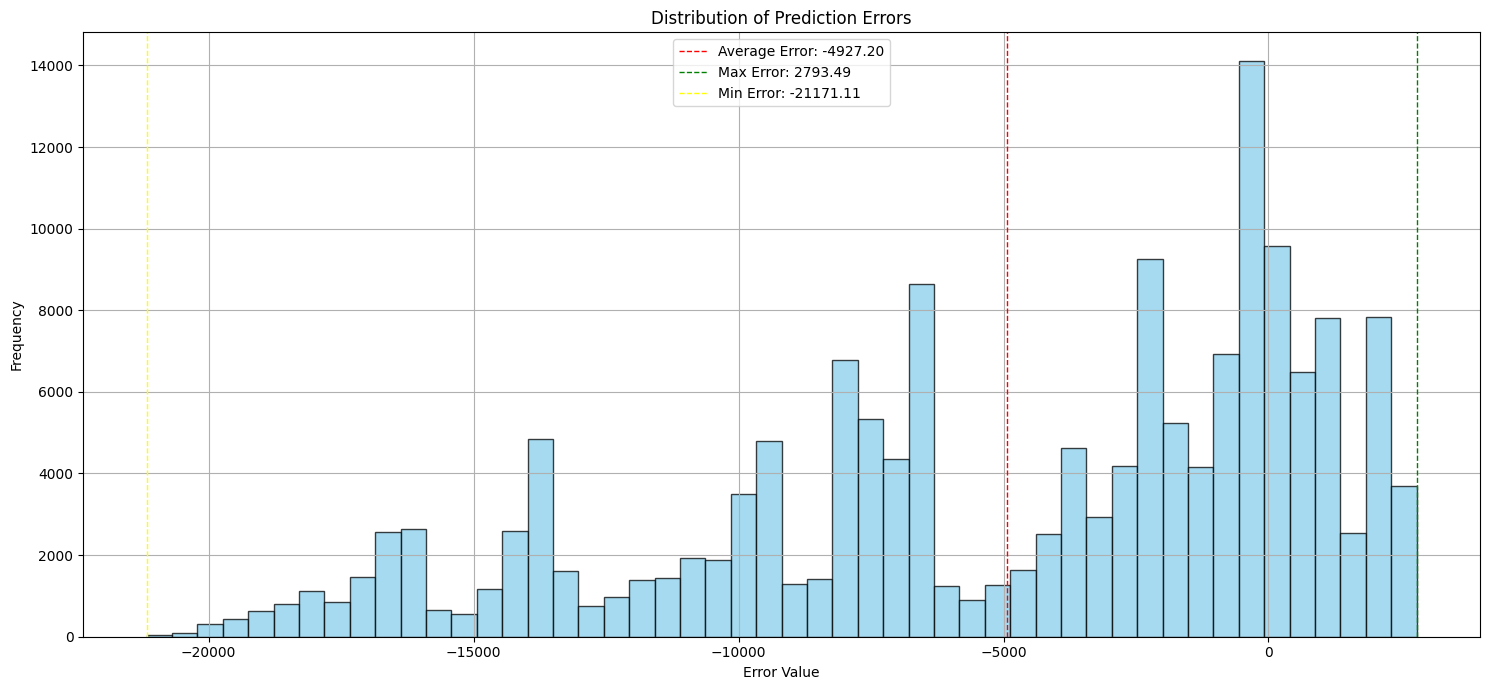


    Model Performance Summary:
    - Trend Prediction Accuracy: 50.29%
    - Average Absolute Error (Correct Trend): $5403.11
    - Average Percentage Error (Correct Trend): 20.11%
    - Overall Average Error: $-4927.20
    - Overall Average Percentage Error: -9.32%
    - Maximum Error: $2793.49
    - Minimum Error: $-21171.11
    - RMSE (Root Mean Squared Error): 7579.03
    
Model Performance Grade: F
The model needs significant improvements before further testing.


In [75]:
#Complete Performance Summary
import pandas as pd
import matplotlib.pyplot as plt

# Shift the 'Close' column up by one to align with 'FCloseNS' for comparison
hist_df['Next_Close'] = hist_df['Close'].shift(-1)

# Calculate the errors
hist_df['Error'] = hist_df['FCloseNS'] - hist_df['Next_Close']

# Calculate percentage error
hist_df['Error%'] = (hist_df['Error'] / hist_df['Next_Close']) * 100

# Metrics
avg_error = hist_df['Error'].mean()
avg_error_percentage = hist_df['Error%'].mean()
max_error = hist_df['Error'].max()
min_error = hist_df['Error'].min()

# Calculate RMSE
errors = hist_df['Next_Close'] - hist_df['FCloseNS']
squared_errors = errors ** 2
mean_squared_error = squared_errors.mean()
rmse = mean_squared_error ** 0.5

# Define trend for both the predicted and actual next close values
# If the value is higher than the current close, it's an upward trend (1), otherwise, it's a downward trend (0)
hist_df['Actual_Trend'] = (hist_df['Next_Close'] > hist_df['Close']).astype(int)
hist_df['Predicted_Trend'] = (hist_df['FCloseNS'] > hist_df['Close']).astype(int)

# Compute the accuracy of the trend prediction
trend_accuracy = (hist_df['Actual_Trend'] == hist_df['Predicted_Trend']).mean()

# Compute the average absolute error for instances where the predicted trend was correct
correct_trend_error = hist_df[hist_df['Actual_Trend'] == hist_df['Predicted_Trend']]['Error'].abs().mean()

# Compute the average percentage error for instances where the predicted trend was correct
correct_trend_error_percentage = hist_df[hist_df['Actual_Trend'] == hist_df['Predicted_Trend']]['Error%'].abs().mean()

trend_accuracy, correct_trend_error, correct_trend_error_percentage

metrics_summary = {
    "Trend Prediction Accuracy": f"{trend_accuracy*100:.2f}%",
    "Average Absolute Error (Correct Trend)": f"{correct_trend_error:.2f}",
    "Average Percentage Error (Correct Trend)": f"{correct_trend_error_percentage:.2f}%",
    "Overall Average Error": f"{avg_error:.2f}",
    "Overall Average Percentage Error": f"{avg_error_percentage:.2f}%",
    "Maximum Error": f"{max_error:.2f}",
    "Minimum Error": f"{min_error:.2f}",
    "RMSE": f"{rmse:.2f}",
}

# Plotting the distribution of errors
plt.figure(figsize=(15, 7))
plt.hist(hist_df['Error'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.75)
plt.axvline(avg_error, color='red', linestyle='dashed', linewidth=1, label=f'Average Error: {avg_error:.2f}')
plt.axvline(max_error, color='green', linestyle='dashed', linewidth=1, label=f'Max Error: {max_error:.2f}')
plt.axvline(min_error, color='yellow', linestyle='dashed', linewidth=1, label=f'Min Error: {min_error:.2f}')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def summarize_performance(metrics):
    summary = f"""
    Model Performance Summary:
    - Trend Prediction Accuracy: {metrics["Trend Prediction Accuracy"]}
    - Average Absolute Error (Correct Trend): ${metrics["Average Absolute Error (Correct Trend)"]}
    - Average Percentage Error (Correct Trend): {metrics["Average Percentage Error (Correct Trend)"]}
    - Overall Average Error: ${metrics["Overall Average Error"]}
    - Overall Average Percentage Error: {metrics["Overall Average Percentage Error"]}
    - Maximum Error: ${metrics["Maximum Error"]}
    - Minimum Error: ${metrics["Minimum Error"]}
    - RMSE (Root Mean Squared Error): {metrics["RMSE"]}
    """
    print(summary)

def grade_performance(trend_accuracy, avg_error_percentage, rmse):
    if trend_accuracy >= 0.80 and avg_error_percentage <= 0.5 and rmse < 0.02:
        return "A+"
    elif trend_accuracy >= 0.75 and avg_error_percentage <= 0.7 and rmse < 0.03:
        return "A"
    elif trend_accuracy >= 0.70 and avg_error_percentage <= 1 and rmse < 0.04:
        return "A-"
    elif trend_accuracy >= 0.65 and avg_error_percentage <= 1.2 and rmse < 0.05:
        return "B+"
    elif trend_accuracy >= 0.60 and avg_error_percentage <= 1.5 and rmse < 0.06:
        return "B"
    elif trend_accuracy >= 0.55 and avg_error_percentage <= 2 and rmse < 0.07:
        return "B-"
    elif trend_accuracy >= 0.50 and avg_error_percentage <= 2.5 and rmse < 0.08:
        return "C+"
    elif trend_accuracy >= 0.45 and avg_error_percentage <= 3 and rmse < 0.09:
        return "C"
    elif trend_accuracy >= 0.40 and avg_error_percentage <= 3.5 and rmse < 0.10:
        return "C-"
    elif trend_accuracy >= 0.35 and avg_error_percentage <= 4 and rmse < 0.12:
        return "D"
    else:
        return "F"

# Summarize the model's performance
summarize_performance(metrics_summary)

# Grade the model's performance
grade = grade_performance(trend_accuracy, avg_error_percentage, rmse)
print(f"Model Performance Grade: {grade}")

if grade == "A" or grade == "B":
    print("The model looks good to be tested further.")
elif grade == "C":
    print("The model is average. Consider improvements before further testing.")
else:
    print("The model needs significant improvements before further testing.")


In [76]:
import pandas as pd
import os


save_path = fr'C:\Users\DJKlaKunG\Desktop\Personal_Document\GitHub\CNN-Bi-LSTM-Research\model-data\SWT-CNN-Bi-LSTM-Model-2\model_data.csv'
# Step 1: Check if the CSV file exists and determine MODEL_NAME
# Ask the user for a model name
user_input = input("Please enter a model name or press Enter to skip: ")

# Check if the user provided a name
if user_input:
    MODEL_NAME = user_input
else:
    # Step 1: Check if the CSV file exists and determine MODEL_NAME
    if os.path.exists(save_path):
        existing_data = pd.read_csv(save_path)
        model_number = len(existing_data) + 1
        MODEL_NAME = f"Model_{model_number:04d}"  # Format the model number with leading zeros
    else:
        MODEL_NAME = "Model_0001"

print(f"Selected Model Name: {MODEL_NAME}")

# Update the model_path with the new MODEL_NAME
model_path = r"C:\Users\DJKlaKunG\Desktop\Personal_Document\GitHub\CNN-Bi-LSTM-Research\model-data\SWT-CNN-Bi-LSTM-Model-2\\" + MODEL_NAME + ".h5"
# Save the model (assuming the model is already trained)
model.save(model_path)


data_dict = {
    "MODEL_NAME": [MODEL_NAME],
    "TICKER_NAME": [TICKET],
    "TIMEFRAME": [interval_str],
    "GRADE": [grade],
    "LOOKBACK": [LOOKBACK],
    "EPOCHS": [EPOCHS],
    "BATCH_SIZE": [BATCH_SIZE],
    "LEARNING_RATE": [LEARNING_RATE],
    "KERNEL_SIZE": [KERNEL_SIZE],
    "FILTERS": [FILTERS],
    "POOL_SIZE": [POOL_SIZE],
    "LSTM_UNITS1": [LSTM_UNITS1],
    "LSTM_UNITS2": [LSTM_UNITS2],
    "ACTIVATION_FUNC": [ACTIVATION_FUNC],
    "LOSS_FUNC": [LOSS_FUNC],
    "PERFORMANCE_METRIC": [str(PERFORMANCE_METRIC)],  # Convert metric to string for saving
    "TOTAL_TIME": [total_time],
    "AVG_TIME_PER_STEP": [avg_time_per_step],
    "Trend Prediction Accuracy": [f"{trend_accuracy*100:.2f}%"],
    "Average Absolute Error (Correct Trend)": [f"{correct_trend_error:.2f}"],
    "Average Percentage Error (Correct Trend)": [f"{correct_trend_error_percentage:.2f}%"],
    "Overall Average Error": [f"{avg_error:.2f}"],
    "Overall Average Percentage Error": [f"{avg_error_percentage:.2f}%"],
    "Maximum Error": [f"{max_error:.2f}"],
    "Minimum Error": [f"{min_error:.2f}"]
}

# Convert dictionary into a DataFrame
df = pd.DataFrame(data_dict)

# Check if the CSV file exists and save data
if os.path.exists(save_path):
    df.to_csv(save_path, mode='a', header=False, index=False)  # Append data without header
else:
    df.to_csv(save_path, index=False)  # Save new file with header

# Display the generated MODEL_NAME for verification


print("Save - Complete " + MODEL_NAME)

Selected Model Name: Model_0001
Save - Complete Model_0001
